<a href="https://colab.research.google.com/github/lakshmishivanik/MLFlow-/blob/main/MLflowUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up the API key and installing dependencies

In [1]:
import os
os.environ["ANTHROPIC_API_KEY"] = "sk-"  # Replace with your actual key

In [2]:
!pip install mlflow pandas datasets transformers anthropic pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Tracking URI: You need to make sure that Notebook 2 knows where to find the MLflow tracking server. If you're using a local tracking server (the default), and you started the tracking server in Notebook 1, then Notebook 2 also needs to point to http://localhost:5000. You can set the MLFLOW_TRACKING_URI environment variable in Notebook 2:



In [3]:
import os
os.environ["MLFLOW_TRACKING_URI"] = "https://1391-34-57-255-3.ngrok-free.app" #Put there your ngrok URI

self-contained code for just loading and wrapping the Claude model to MLflow, ready to be executed in a Colab notebook:

In [4]:
import mlflow
import anthropic
import os
import pandas as pd
from typing import Dict, Any, List

# 1. Define the ClaudeModelWrapper class
class ClaudeModelWrapper(mlflow.pyfunc.PythonModel):
    """A custom MLflow model that wraps the Anthropic Claude API."""

    def __init__(self, model_name: str, system_prompt: str):
        self.model_name = model_name
        self.system_prompt = system_prompt
        self.anthropic_api_key = os.environ.get("ANTHROPIC_API_KEY")

    def load_context(self, context: mlflow.pyfunc.model.PythonModelContext) -> None:
        """Loads artifacts (none in this case)."""
        if not self.anthropic_api_key:
            raise ValueError("Anthropic API key not found. Set ANTHROPIC_API_KEY environment variable.")

    def predict(self, context: mlflow.pyfunc.model.PythonModelContext, model_input: pd.DataFrame) -> list[str]:
        """
        Generates predictions using the Claude API.

        Args:
            context: MLflow context (unused).
            model_input: Pandas DataFrame with a 'question' column containing prompts.

        Returns:
            List of responses from Claude.
        """
        client = anthropic.Anthropic()
        responses = []
        for question in model_input["question"]:
            try:
                message = client.messages.create(
                    model=self.model_name,
                    max_tokens=1024,
                    system = self.system_prompt,
                    messages=[
                        {"role": "user", "content": question}
                    ],
                )
                responses.append(message.content[0].text)
            except Exception as e:
                print(f"Error calling Claude API: {e}")
                responses.append(None)  # Or a suitable error value
        return responses

# 2. Set up the Experiment and Tracking
# (Optional, but recommended for organization)
mlflow.set_experiment("claude_wrapping")

# 3. Run
with mlflow.start_run() as run:
    # 4. Define Claude Model and System Prompt
    claude_model_name = "claude-3-opus-20240229"  # Or an appropriate Claude model. Change the model with one that is accesible
    system_prompt = "Answer the following question concisely."

    # 5. Create the ClaudeModelWrapper Instance
    claude_model = ClaudeModelWrapper(model_name=claude_model_name, system_prompt=system_prompt)

    # 6. Log the MLflow Model
    mlflow.pyfunc.log_model(
        python_model=claude_model,
        artifact_path="claude_model",
        input_example=pd.DataFrame({"question": ["What is the capital of France?"]}),
    )

    print(f"Successfully logged Claude model to run: {run.info.run_id}")

2025/03/07 04:59:26 INFO mlflow.tracking.fluent: Experiment with name 'claude_wrapping' does not exist. Creating a new experiment.
2025/03/07 04:59:27 INFO mlflow.pyfunc: Inferring model signature from input example
2025/03/07 04:59:37 INFO mlflow.models.model: Found the following environment variables used during model inference: [ANTHROPIC_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


Successfully logged Claude model to run: 6c29e48f2e334209b6d2190a1aed634f
🏃 View run puzzled-ray-28 at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534/runs/6c29e48f2e334209b6d2190a1aed634f
🧪 View experiment at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534


In [5]:
import mlflow
import pandas as pd
import anthropic
import os

# 1. Install Dependencies (Run this cell once if you haven't already)
!pip install mlflow anthropic pandas

# 2. Set Your Anthropic API Key (Replace with your actual key!)
os.environ["ANTHROPIC_API_KEY"] = "sk-"  # Replace!

# 3. Configuration
# 4. Define your model run ID
model_run_id = "6c29e48f2e334209b6d2190a1aed634f"

# Set your model and experiment name
claude_model_name = "claude-3-opus-20240229" # @param {type:"string"}
MLFLOW_EXPERIMENT_NAME = "claude_wrapping" # @param {type:"string"}

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

# Check is the api key is accesible
if not os.environ.get("ANTHROPIC_API_KEY"):
  raise ValueError("Anthropic API key not found. Set ANTHROPIC_API_KEY environment variable.")

# 5. Load the Model (Replace with the correct Model URI)
model_uri = 'runs:/6c29e48f2e334209b6d2190a1aed634f/claude_model'
loaded_model = mlflow.pyfunc.load_model(model_uri) # Load only once, to save in the test.

# 6. Define the evaluation Function
def get_claude_judgment(question, answer, ground_truth, prompt, claude_model_id):
  """Calls Claude API for evaluation and returns a tuple (score, justification) or (1, "Error") on error."""
  try:
      client = anthropic.Anthropic()
      message = client.messages.create(
          model=claude_model_id,
          max_tokens=300,
          system=prompt,
          messages=[{"role": "user", "content": f"Question: {question}\nAnswer: {answer}\nGround Truth: {ground_truth}"}],
      )
      claude_response = message.content[0].text
      try:  # Safely extract score and justification
          score = int(claude_response.split()[0])
          justification = " ".join(claude_response.split()[1:])
          return score, justification
      except (ValueError, IndexError):
          print(f"Could not parse Claude's response: {claude_response}")  # More specific message
          return 1, "Could not parse Claude's response."

  except Exception as e:
      print(f"Error calling Claude API: {e}")
      return 1, "Error during evaluation."  # Consistent return


def claude_evaluate(model, data, claude_model_id):
  question = data["question"].tolist()
  answers = model.predict(data)
  ground_truth = data["ground_truth"].tolist()
  scores = []
  justifications = []

  for index in range(len(data)):
    score, justification = get_claude_judgment(question = question[index], answer = answers[index], ground_truth = ground_truth[index], prompt = "You will score from 1 to 5 the answer, comparing it with the Ground Truth", claude_model_id = claude_model_id)
    scores.append(score)
    justifications.append(justification)

  result = sum(scores)/len(scores)

  return {"score":result}

# 7. Define Evaluation Data
eval_data = pd.DataFrame({
    "question": [
        "What is MLflow?",
        "What is Spark?",
    ],
    "ground_truth": [
        "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
        "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
    ]
})

# 8. Evaluate the Model
try:
  with mlflow.start_run() as run: #Create a run for this
    results = claude_evaluate(loaded_model, eval_data, claude_model_name) #added to the load and eval function, with name of Claude

    mlflow.log_metric("mean_score", results["score"]) # Log a metric value
    print(f"Evaluation Results: {results}")

except Exception as e:
    print(f"An error occurred during the MLflow run: {e}")

2025/03/07 05:01:18 WARNING mlflow.models.utils: Found extra inputs in the model input that are not defined in the model signature: `['ground_truth']`. These inputs will be ignored.


Could not parse Claude's response: The given answer provides a comprehensive explanation of MLflow and its key features. It covers the main aspects of MLflow, including:

1. Defining MLflow as an open-source platform for managing the end-to-end machine learning lifecycle.
2. Mentioning the tools and APIs provided by MLflow to track experiments, package code, share and deploy models, and manage MLOps.
3. Describing the key features of MLflow, such as tracking, projects, models, model registry, and deployment options.
4. Highlighting MLflow's integration with various ML libraries and frameworks.
5. Stating that MLflow can be used as a standalone tool or integrated into existing workflows and platforms.

The answer goes beyond the basic definition provided in the ground truth and elaborates on the essential aspects of MLflow. It provides a clear and informative explanation suitable for someone who wants to understand what MLflow is and its main capabilities.

Considering the comprehensive

In [6]:
import mlflow
import pandas as pd
import anthropic
import os

# 2. Set Your Anthropic API Key (Replace with your actual key!)
os.environ["ANTHROPIC_API_KEY"] = "sk-"  # Replace!

# 3. Configuration
# 4. Define your model run ID
model_run_id = "6c29e48f2e334209b6d2190a1aed634f" # Fill the run of an older saved model!

# Set your model and experiment name
claude_model_name = "claude-3-opus-20240229" # @param {type:"string"}
MLFLOW_EXPERIMENT_NAME = "claude_wrapping" # @param {type:"string"}

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

# Check is the api key is accesible
if not os.environ.get("ANTHROPIC_API_KEY"):
  raise ValueError("Anthropic API key not found. Set ANTHROPIC_API_KEY environment variable.")

# 5. Load the Model (Replace with the correct Model URI)
model_uri = 'runs:/6c29e48f2e334209b6d2190a1aed634f/claude_model'
loaded_model = mlflow.pyfunc.load_model(model_uri) # Load only once, to save in the test.

# 6. Define the evaluation Function
def get_claude_judgment(question, answer, ground_truth, prompt, claude_model_id):
  """Calls Claude API for evaluation and returns a tuple (score, justification) or (1, "Error") on error."""
  try:
      client = anthropic.Anthropic()
      message = client.messages.create(
          model=claude_model_id,
          max_tokens=300,
          system=prompt,
          messages=[{"role": "user", "content": f"Question: {question}\nAnswer: {answer}\nGround Truth: {ground_truth}"}],
      )
      claude_response = message.content[0].text
      try:  # Safely extract score and justification
          score = int(claude_response.split()[0])
          justification = " ".join(claude_response.split()[1:])
          return score, justification
      except (ValueError, IndexError):
          print(f"Could not parse Claude's response: {claude_response}")  # More specific message
          return 1, "Could not parse Claude's response."

  except Exception as e:
      print(f"Error calling Claude API: {e}")
      return 1, "Error during evaluation."  # Consistent return


# 7. Load and eval
def claude_evaluate(eval_data, claude_model_name, loaded_model):

    question = eval_data["question"].tolist()
    ground_truth = eval_data["ground_truth"].tolist()
    scores = []
    justifications = []

    #Here I use the Claude Directly and No call the previous functions, so there will be no issue
    for index in range(len(eval_data)):

        client = anthropic.Anthropic() #Using this fixes the issues!
        try:
          message = client.messages.create(
              model=claude_model_name,
              max_tokens=1024,
              system = "You will evaluate the answer based on the Ground Turth",
              messages=[
                  {"role": "user", "content": f"Question: {question[index]}\n Ground Truth:{ground_truth[index]}"} # Now the System Role is at the top
              ],
          )
          #After having the model, you can get the proper judgement

          score, justification = get_claude_judgment(question = question[index], answer = message.content[0].text, ground_truth = ground_truth[index], prompt = "You will score from 1 to 5 the answer, comparing it with the Ground Truth", claude_model_id = claude_model_name)
          scores.append(score)
          justifications.append(justification)

        except Exception as e:
            print(f"Error calling Claude API: {e}")
            score = 1 #Put the lowest score in case of failure
            justification = "Failure from the bot"
            scores.append(score)
            justifications.append(justification)

    result = sum(scores)/len(scores) #Just compute the final score
    print(f"Justifications: {justifications}")

    return {"score":result}

# 8. Define Evaluation Data
eval_data = pd.DataFrame({
    "question": [
        "What is MLflow?",
        "What is Spark?",
    ],
    "ground_truth": [
        "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
        "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
    ]
})

try:
  with mlflow.start_run() as run: #Create a run for this
    results = claude_evaluate(eval_data, claude_model_name, loaded_model) #Just need to load

    mlflow.log_metric("mean_score", results["score"]) #Log a metric value
    print(f"Evaluation Results: {results}")

except Exception as e:
    print(f"An error occurred during the MLflow run: {e}")

Could not parse Claude's response: The provided answer is a comprehensive and accurate explanation of MLflow, covering its key features, components, and benefits. The answer touches upon the main aspects of MLflow, such as:

1. Tracking experiments
2. Packaging code for reproducibility
3. Model management and deployment
4. Model registry for collaboration and lifecycle management
5. User interface for visualization and comparison

The answer also highlights how MLflow helps organizations increase productivity and improve the quality of their ML applications by providing a unified platform for experimentation and deployment.

Compared to the ground truth, which is a concise one-line definition, the given answer provides a more detailed and informative explanation of MLflow and its functionalities.

Score: 5
Could not parse Claude's response: I would rate your answer as a 5 out of 5 when compared to the given ground truth. Your response accurately captures the essence of Apache Spark as 

In [7]:
!pip install mlflow anthropic pandas textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.7 MB/s eta 0:00:00


In [8]:
import mlflow
import anthropic
import pandas as pd
import os
from typing import List
import textstat  # For readability metrics

# 1. Set Your Anthropic API Key
os.environ["ANTHROPIC_API_KEY"] = "sk-"  # Replace!

# 2. Define Evaluation Data
eval_data = pd.DataFrame(
    {
        "inputs": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models.",
            "Apache Spark is an open-source, distributed computing system designed for big data processing and analytics. It was developed in response to limitations of the Hadoop MapReduce computing model, offering improvements in speed and ease of use. Spark provides libraries for various tasks such as data ingestion, processing, and analysis through its components like Spark SQL for structured data, Spark Streaming for real-time data processing, and MLlib for machine learning tasks",
        ],
    }
)

# 3. Define the Claude Model Function
def anthropic_qa(inputs: pd.DataFrame) -> List[str]:
    """
    Generates responses using the Anthropic Claude API.

    Args:
        inputs: A Pandas DataFrame with an 'inputs' column containing prompts.

    Returns:
        A list of Claude's responses.
    """
    predictions = []
    system_prompt = "Please answer the following question in formal language."
    client = anthropic.Anthropic()

    for _, row in inputs.iterrows():
        try:
            message = client.messages.create(
                model="claude-3-opus-20240229",  # Replace with an available Claude model for you
                max_tokens=1024,
                system= system_prompt,
                messages=[
                    {"role": "user", "content": row["inputs"]},
                ],
            )
            predictions.append(message.content[0].text)
        except Exception as e:
            print(f"Error calling Claude API: {e}")
            predictions.append(None)  # Or a suitable error value

    return predictions

# 4. Define the all the custom metric in just a func
def calculate_metrics(df):

  flesch_kincaid_grade_levels = []
  ari_grade_levels = []
  exact_matches = []

  for _, row in df.iterrows():
        # Readability metrics
        flesch_kincaid_grade_level = textstat.flesch_kincaid_grade(row["predictions"])
        ari_grade_level = textstat.automated_readability_index(row["predictions"])

        flesch_kincaid_grade_levels.append(flesch_kincaid_grade_level)
        ari_grade_levels.append(ari_grade_level)

        # Exact match (basic, case-insensitive)
        exact_match = 1.0 if row["ground_truth"].lower() == row["predictions"].lower() else 0.0
        exact_matches.append(exact_match)

  # Compute the mean, variance, and 90th percentile using list comprehensions
  flesch_kincaid_grade_level_mean = sum(flesch_kincaid_grade_levels) / len(flesch_kincaid_grade_levels)
  flesch_kincaid_grade_level_variance = sum([(x - flesch_kincaid_grade_level_mean) ** 2 for x in flesch_kincaid_grade_levels]) / len(flesch_kincaid_grade_levels) # Compute unbiased Variance
  flesch_kincaid_grade_level_p90 = sorted(flesch_kincaid_grade_levels)[int(0.9 * len(flesch_kincaid_grade_levels))]

  ari_grade_level_mean = sum(ari_grade_levels) / len(ari_grade_levels)
  ari_grade_level_variance = sum([(x - ari_grade_level_mean) ** 2 for x in ari_grade_levels]) / len(ari_grade_levels) # Compute unbiased Variance
  ari_grade_level_p90 = sorted(ari_grade_levels)[int(0.9 * len(ari_grade_levels))]

  exact_match_mean = sum(exact_matches) / len(exact_matches)

  return {
          "flesch_kincaid_grade_level/v1/mean": flesch_kincaid_grade_level_mean,
          "flesch_kincaid_grade_level/v1/variance": flesch_kincaid_grade_level_variance,
          "flesch_kincaid_grade_level/v1/p90": flesch_kincaid_grade_level_p90,
          "ari_grade_level/v1/mean": ari_grade_level_mean,
          "ari_grade_level/v1/variance": ari_grade_level_variance,
          "ari_grade_level/v1/p90": ari_grade_level_p90,
          "exact_match/v1": exact_match_mean
      }

# 5. Run the evaluation
with mlflow.start_run():
    # Generate Claude model outputs
    predictions = anthropic_qa(eval_data)
    eval_data["predictions"] = predictions

    metrics = calculate_metrics(eval_data) # Calculate the metrics on the new predictions

    # Log results
    mlflow.log_metrics(metrics)

    print(f"Metrics: {metrics}")
    print(eval_data)  # Display the dataframe with the responses and metrics

Metrics: {'flesch_kincaid_grade_level/v1/mean': 15.1, 'flesch_kincaid_grade_level/v1/variance': 0.8100000000000006, 'flesch_kincaid_grade_level/v1/p90': 16.0, 'ari_grade_level/v1/mean': 18.1, 'ari_grade_level/v1/variance': 0.35999999999999954, 'ari_grade_level/v1/p90': 18.7, 'exact_match/v1': 0.0}
            inputs                                       ground_truth  \
0  What is MLflow?  MLflow is an open-source platform for managing...   
1   What is Spark?  Apache Spark is an open-source, distributed co...   

                                         predictions  
0  MLflow is an open-source platform designed to ...  
1  Apache Spark is an open-source, distributed co...  
🏃 View run vaunted-fly-288 at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534/runs/ae2358e1ab8d479d8cd5b2fcdbbe1047
🧪 View experiment at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534


In [9]:
import mlflow
import anthropic
import pandas as pd
import os
from typing import List
import textstat  # For readability metrics
import re

# 1. Set Your Anthropic API Key
os.environ["ANTHROPIC_API_KEY"] = "sk-"  # Replace!

# 2. Define Evaluation Data
eval_data = pd.DataFrame(
    {
        "inputs": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models.",
            "Apache Spark is an open-source, distributed computing system designed for big data processing and analytics. It was developed in response to limitations of the Hadoop MapReduce computing model, offering improvements in speed and ease of use. Spark provides libraries for various tasks such as data ingestion, processing, and analysis through its components like Spark SQL for structured data, Spark Streaming for real-time data processing, and MLlib for machine learning tasks",
        ],
    }
)

# 3. Define the Claude Model Function
def anthropic_qa(inputs: pd.DataFrame) -> List[str]:
    """
    Generates responses using the Anthropic Claude API.

    Args:
        inputs: A Pandas DataFrame with an 'inputs' column containing prompts.

    Returns:
        A list of Claude's responses.
    """
    predictions = []
    system_prompt = "Please answer the following question in formal language."
    client = anthropic.Anthropic()

    for _, row in inputs.iterrows():
        try:
            message = client.messages.create(
                model="claude-3-opus-20240229",  # Replace with an available Claude model for you
                max_tokens=1024,
                system= system_prompt,
                messages=[
                    {"role": "user", "content": row["inputs"]},
                ],
            )
            predictions.append(message.content[0].text)
        except Exception as e:
            print(f"Error calling Claude API: {e}")
            predictions.append(None)  # Or a suitable error value

    return predictions

# 4. Define the all the custom metric in just a func
def calculate_metrics(df):

  flesch_kincaid_grade_levels = []
  ari_grade_levels = []
  exact_matches = []

  def normalize_text(text):
      text = text.lower().strip()  # Convert to lowercase and remove whitespace
      text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
      return text

  for _, row in df.iterrows():
        # Readability metrics
        flesch_kincaid_grade_level = textstat.flesch_kincaid_grade(row["predictions"])
        ari_grade_level = textstat.automated_readability_index(row["predictions"])

        flesch_kincaid_grade_levels.append(flesch_kincaid_grade_level)
        ari_grade_levels.append(ari_grade_level)

        # Exact match (basic, case-insensitive)
        normalized_ground_truth = normalize_text(row['ground_truth'])
        normalized_prediction = normalize_text(row['predictions'])
        exact_match = 1.0 if normalized_ground_truth == normalized_prediction else 0.0
        exact_matches.append(exact_match)

  # Compute the mean, variance, and 90th percentile using list comprehensions
  flesch_kincaid_grade_level_mean = sum(flesch_kincaid_grade_levels) / len(flesch_kincaid_grade_levels)
  flesch_kincaid_grade_level_variance = sum([(x - flesch_kincaid_grade_level_mean) ** 2 for x in flesch_kincaid_grade_levels]) / len(flesch_kincaid_grade_levels) # Compute unbiased Variance
  flesch_kincaid_grade_level_p90 = sorted(flesch_kincaid_grade_levels)[int(0.9 * len(flesch_kincaid_grade_levels))]

  ari_grade_level_mean = sum(ari_grade_levels) / len(ari_grade_levels)
  ari_grade_level_variance = sum([(x - ari_grade_level_mean) ** 2 for x in ari_grade_levels]) / len(ari_grade_levels) # Compute unbiased Variance
  ari_grade_level_p90 = sorted(ari_grade_levels)[int(0.9 * len(ari_grade_levels))]

  exact_match_mean = sum(exact_matches) / len(exact_matches)

  return {
          "flesch_kincaid_grade_level/v1/mean": flesch_kincaid_grade_level_mean,
          "flesch_kincaid_grade_level/v1/variance": flesch_kincaid_grade_level_variance,
          "flesch_kincaid_grade_level/v1/p90": flesch_kincaid_grade_level_p90,
          "ari_grade_level/v1/mean": ari_grade_level_mean,
          "ari_grade_level/v1/variance": ari_grade_level_variance,
          "ari_grade_level/v1/p90": ari_grade_level_p90,
          "exact_match/v1": exact_match_mean
      }

# 5. Run the evaluation
with mlflow.start_run():
    # Generate Claude model outputs
    predictions = anthropic_qa(eval_data)
    eval_data["predictions"] = predictions

    metrics = calculate_metrics(eval_data)  # Calculate the metrics on the new predictions

    # Log results
    mlflow.log_metrics(metrics)

    print(f"Metrics: {metrics}")
    print(eval_data)  # Display the dataframe with the responses and metrics

Metrics: {'flesch_kincaid_grade_level/v1/mean': 14.600000000000001, 'flesch_kincaid_grade_level/v1/variance': 2.8900000000000006, 'flesch_kincaid_grade_level/v1/p90': 16.3, 'ari_grade_level/v1/mean': 17.4, 'ari_grade_level/v1/variance': 0.25, 'ari_grade_level/v1/p90': 17.9, 'exact_match/v1': 0.0}
            inputs                                       ground_truth  \
0  What is MLflow?  MLflow is an open-source platform for managing...   
1   What is Spark?  Apache Spark is an open-source, distributed co...   

                                         predictions  
0  MLflow is an open-source platform designed to ...  
1  Apache Spark is an open-source, distributed co...  
🏃 View run fun-gnu-999 at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534/runs/646282cf76da4d9190494daf62bb0ddd
🧪 View experiment at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534


In [10]:
import mlflow
import pandas as pd
from mlflow.metrics import make_metric

# 1. Define Evaluation Data (with pre-computed predictions)
eval_data = pd.DataFrame({
    "inputs": [
        "What is MLflow?",
        "What is Spark?",
    ],
    "ground_truth": [
        "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
        "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
    ],
    "predictions": [ # Model is not run, so you need to load the answers into the model output
        "MLflow is a platform for managing the ML lifecycle.",
        "Spark is a fast, general-purpose cluster computing system."
    ]
})

# 2. Create a simple, basic metrics
def simple_metric(row):
        if row["ground_truth"].lower() in row["predictions"].lower(): # comparing if the ground_truth is in the response
            return 1.0
        else:
            return 0.0

# 3. Start MLflow and make the evaluation
with mlflow.start_run() as run:
    eval_data["metric"] = eval_data.apply(simple_metric, axis=1)  # Apply the metric to each row
    average_metric = eval_data["metric"].mean()  # calculate the average of the metric

    # Log results
    mlflow.log_metric("simple_matching_accuracy", average_metric) # Log the simple matching accuracy
    print(f"Simple Matching Accuracy: {average_metric}")

    print(eval_data)  # Display the dataframe with the responses and metrics

Simple Matching Accuracy: 0.0
            inputs                                       ground_truth  \
0  What is MLflow?  MLflow is an open-source platform for managing...   
1   What is Spark?  Apache Spark is a fast, general-purpose cluste...   

                                         predictions  metric  
0  MLflow is a platform for managing the ML lifec...     0.0  
1  Spark is a fast, general-purpose cluster compu...     0.0  
🏃 View run zealous-goose-676 at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534/runs/8cf89a5f669e4fa4aadb587cd4641dbf
🧪 View experiment at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534


In [11]:
import mlflow
import anthropic
import pandas as pd
import os
from typing import List
import textstat  # For readability metrics
import re
from mlflow.data import from_pandas
import tempfile #Import temporal directory

# 1. Set Your Anthropic API Key
os.environ["ANTHROPIC_API_KEY"] = "sk-"  # Replace!

# 2. Define Evaluation Data
eval_data = pd.DataFrame(
    {
        "inputs": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. It was developed by Databricks, a company that specializes in big data and machine learning solutions. MLflow is designed to address the challenges that data scientists and machine learning engineers face when developing, training, and deploying machine learning models.",
            "Apache Spark is an open-source, distributed computing system designed for big data processing and analytics. It was developed in response to limitations of the Hadoop MapReduce computing model, offering improvements in speed and ease of use. Spark provides libraries for various tasks such as data ingestion, processing, and analysis through its components like Spark SQL for structured data, Spark Streaming for real-time data processing, and MLlib for machine learning tasks",
        ],
    }
)

# 3. Define the Claude Model Function
def anthropic_qa(inputs: pd.DataFrame) -> List[str]:
    """
    Generates responses using the Anthropic Claude API.

    Args:
        inputs: A Pandas DataFrame with an 'inputs' column containing prompts.

    Returns:
        A list of Claude's responses.
    """
    predictions = []
    system_prompt = "Please answer the following question in formal language."
    client = anthropic.Anthropic()

    for _, row in inputs.iterrows():
        try:
            message = client.messages.create(
                model="claude-3-opus-20240229",  # Replace with an available Claude model for you
                max_tokens=1024,
                system= system_prompt,
                messages=[
                    {"role": "user", "content": row["inputs"]},
                ],
            )
            predictions.append(message.content[0].text)
        except Exception as e:
            print(f"Error calling Claude API: {e}")
            predictions.append(None)  # Or a suitable error value

    return predictions

# 4. Define the all the custom metric in just a func
def calculate_metrics(df):

  flesch_kincaid_grade_levels = []
  ari_grade_levels = []
  exact_matches = []

  def normalize_text(text):
      text = text.lower().strip()  # Convert to lowercase and remove whitespace
      text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
      return text

  for _, row in df.iterrows():
        # Readability metrics
        flesch_kincaid_grade_level = textstat.flesch_kincaid_grade(row["predictions"])
        ari_grade_level = textstat.automated_readability_index(row["predictions"])

        flesch_kincaid_grade_levels.append(flesch_kincaid_grade_level)
        ari_grade_levels.append(ari_grade_level)

        # Exact match (basic, case-insensitive)
        normalized_ground_truth = normalize_text(row['ground_truth'])
        normalized_prediction = normalize_text(row['predictions'])
        exact_match = 1.0 if normalized_ground_truth == normalized_prediction else 0.0
        exact_matches.append(exact_match)

  # Compute the mean, variance, and 90th percentile using list comprehensions
  flesch_kincaid_grade_level_mean = sum(flesch_kincaid_grade_levels) / len(flesch_kincaid_grade_levels)
  flesch_kincaid_grade_level_variance = sum([(x - flesch_kincaid_grade_level_mean) ** 2 for x in flesch_kincaid_grade_levels]) / len(flesch_kincaid_grade_levels) # Compute unbiased Variance
  flesch_kincaid_grade_level_p90 = sorted(flesch_kincaid_grade_levels)[int(0.9 * len(flesch_kincaid_grade_levels))]

  ari_grade_level_mean = sum(ari_grade_levels) / len(ari_grade_levels)
  ari_grade_level_variance = sum([(x - ari_grade_level_mean) ** 2 for x in ari_grade_levels]) / len(ari_grade_levels) # Compute unbiased Variance
  ari_grade_level_p90 = sorted(ari_grade_levels)[int(0.9 * len(ari_grade_levels))]

  exact_match_mean = sum(exact_matches) / len(exact_matches)

  return {
          "flesch_kincaid_grade_level/v1/mean": flesch_kincaid_grade_level_mean,
          "flesch_kincaid_grade_level/v1/variance": flesch_kincaid_grade_level_variance,
          "flesch_kincaid_grade_level/v1/p90": flesch_kincaid_grade_level_p90,
          "ari_grade_level/v1/mean": ari_grade_level_mean,
          "ari_grade_level/v1/variance": ari_grade_level_variance,
          "ari_grade_level/v1/p90": ari_grade_level_p90,
          "exact_match/v1": exact_match_mean
      }

# 5. Run the evaluation
with mlflow.start_run() as run:
    # Generate Claude model outputs
    predictions = anthropic_qa(eval_data)
    eval_data["predictions"] = predictions

    metrics = calculate_metrics(eval_data)  # Calculate the metrics on the new predictions

    # Log results
    mlflow.log_metrics(metrics)

    print(f"Metrics: {metrics}")
    print(eval_data)  # Display the dataframe with the responses and metrics
# Temp csv save + upload
    with tempfile.TemporaryDirectory() as tmpdir:
        csv_path = os.path.join(tmpdir, "eval_results.csv")
        eval_data.to_csv(csv_path, index=False)  # Save without index
        mlflow.log_artifact(csv_path, artifact_path="eval_results_table")

Metrics: {'flesch_kincaid_grade_level/v1/mean': 12.65, 'flesch_kincaid_grade_level/v1/variance': 3.0625, 'flesch_kincaid_grade_level/v1/p90': 14.4, 'ari_grade_level/v1/mean': 14.950000000000001, 'ari_grade_level/v1/variance': 2.722500000000001, 'ari_grade_level/v1/p90': 16.6, 'exact_match/v1': 0.0}
            inputs                                       ground_truth  \
0  What is MLflow?  MLflow is an open-source platform for managing...   
1   What is Spark?  Apache Spark is an open-source, distributed co...   

                                         predictions  
0  MLflow is an open-source platform designed to ...  
1  Apache Spark is an open-source, distributed co...  
🏃 View run bedecked-mole-276 at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534/runs/ca228bd781fa4cc6b5103be5153ecd3d
🧪 View experiment at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534


OK, let's break down the steps to create a proper custom mlflow.pyfunc.PythonModel wrapper for your Claude model and configure the evaluation correctly, all consolidated into a single, streamlined workflow.

#Step 1: Create the ClaudeModelWrapper Class

This class is a critical component. It's responsible for handling the interaction with the Claude API and ensuring that the Claude model can be treated as a standard MLflow model.

In [12]:
import mlflow
import anthropic
import os
import pandas as pd
from typing import Dict, Any, List

class ClaudeModelWrapper(mlflow.pyfunc.PythonModel):
    """
    A custom MLflow model that wraps the Anthropic Claude API.
    """

    def __init__(self, model_name: str, system_prompt: str):
        self.model_name = model_name
        self.system_prompt = system_prompt
        self.anthropic_api_key = os.environ.get("ANTHROPIC_API_KEY")

    def load_context(self, context: mlflow.pyfunc.model.PythonModelContext) -> None:
        """Loads artifacts (none in this case)."""
        if not self.anthropic_api_key:
            raise ValueError("Anthropic API key not found. Set ANTHROPIC_API_KEY environment variable.")

    def predict(self, context: mlflow.pyfunc.model.PythonModelContext, model_input: pd.DataFrame) -> List[str]:
        """
        Generates predictions using the Claude API.

        Args:
            context: MLflow context (unused).
            model_input: Pandas DataFrame with a 'question' column containing prompts.

        Returns:
            List of responses from Claude.
        """
        client = anthropic.Anthropic()
        responses = []
        for question in model_input["question"]:
            try:
                message = client.messages.create(
                    model=self.model_name,
                    max_tokens=1024,
                    system = self.system_prompt,
                    messages=[
                        {"role": "user", "content": question}
                    ],
                )
                responses.append(message.content[0].text)
            except Exception as e:
                print(f"Error calling Claude API: {e}")
                responses.append(None)  # Or a suitable error value
        return responses

#Create Evaluation Data:

In [13]:
import pandas as pd

eval_data = pd.DataFrame({
    "question": [
        "What is MLflow?",
        "What is Spark?",
    ],
    "ground_truth": [
        "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
        "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
    ]
})

#Log and save the MLflow Model:

In [14]:
import mlflow
import pandas as pd
from mlflow.models import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
with mlflow.start_run() as run:
    claude_model_name = "claude-3-opus-20240229"  # Replace with an available Claude model
    system_prompt = "Answer the following question in two sentences."

    claude_model = ClaudeModelWrapper(model_name=claude_model_name, system_prompt=system_prompt)

    # Infer the signature (input/output types)
    signature = infer_signature(
        eval_data[["question"]],  # Input data (only the "question" column)
        claude_model.predict(context=None, model_input=eval_data[["question"]]) # Infer the signature of the output
    )

    # Create a Conda environment for the model (optional but recommended)
    conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["anthropic", "textstat"] # Add the necessary packages
    )

    mlflow.pyfunc.log_model(
        python_model=claude_model,
        artifact_path="claude_model",
        signature=signature,
        conda_env=conda_env,
        input_example=eval_data[["question"]].head(1), # Example of input data
    )

    logged_model_uri = f"runs:/{run.info.run_id}/claude_model"

    print(f"Successfully logged Claude model to run: {run.info.run_id}")

2025/03/07 05:08:59 INFO mlflow.pyfunc: Validating input example against model signature
2025/03/07 05:09:01 INFO mlflow.models.model: Found the following environment variables used during model inference: [ANTHROPIC_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


Successfully logged Claude model to run: 3b9bb60915d04245a43e488b2abe654e
🏃 View run indecisive-dove-824 at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534/runs/3b9bb60915d04245a43e488b2abe654e
🧪 View experiment at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534


In [15]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.9 MB/s eta 0:00:00


In [16]:
!pip install mlflow anthropic pandas textstat evaluate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00


#Evaluate the Model: Now you can evaluate the model

##Evaluating with a Custom Function
As of MLflow 2.8.0, mlflow.evaluate() supports evaluating a python function without requiring logging the model to MLflow. This is useful when you don't want to log the model and just want to evaluate it. The following example uses mlflow.evaluate() to evaluate a function. You also need to set up OpenAI authentication to run the code below.

In [18]:
pip install --upgrade mlflow

In [20]:
    import mlflow
    import pandas as pd

    #Load the test data
    eval_data = pd.DataFrame({
        "question": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
            "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
        ]
    })

    with mlflow.start_run() as run:
        # Evaluate the model using the 'question-answering' model type
        results = mlflow.evaluate(
            model='runs:/3b9bb60915d04245a43e488b2abe654e/claude_model',  # Or wherever it has been logged
            data=eval_data,
            model_type="question-answering",  # Use "question-answering" model_type
            targets="ground_truth", # Select which colums must be matched
        )

        # Print the evaluation results
        print(results.metrics)

2025/03/07 05:13:23 INFO mlflow.models.evaluation.utils.trace: Auto tracing is temporarily enabled during the model evaluation for computing some metrics and debugging. To disable tracing, call `mlflow.autolog(disable=True)`.
2025/03/07 05:13:23 INFO mlflow.models.evaluation.evaluators.default: Computing model predictions.
2025/03/07 05:13:28 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


{'toxicity/v1/mean': 0.0001428796531399712, 'toxicity/v1/variance': 3.0341924659970363e-12, 'toxicity/v1/p90': 0.00014427316782530397, 'toxicity/v1/ratio': 0.0, 'flesch_kincaid_grade_level/v1/mean': 13.649999999999999, 'flesch_kincaid_grade_level/v1/variance': 6.5024999999999995, 'flesch_kincaid_grade_level/v1/p90': 15.69, 'ari_grade_level/v1/mean': 16.35, 'ari_grade_level/v1/variance': 0.42250000000000043, 'ari_grade_level/v1/p90': 16.87, 'exact_match/v1': 0.0}
🏃 View run dazzling-penguin-512 at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534/runs/40e131d5ba1a4974aca2ee8333715fd2
🧪 View experiment at: https://1391-34-57-255-3.ngrok-free.app/#/experiments/922076445686598534


[Trace(request_id=fc959f2d29c048e3853916bef9ec376f), Trace(request_id=ab4be8229ef44a80945a341a1979f2c9)]

In [ ]:
    import mlflow
    import pandas as pd

    #Load the test data
    eval_data = pd.DataFrame({
        "question": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
            "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
        ]
    })

    with mlflow.start_run() as run:
        # Evaluate the model using the 'question-answering' model type
        results = mlflow.evaluate(
            model='runs:/3b9bb60915d04245a43e488b2abe654e/claude_model',  # Or wherever it has been logged
            data=eval_data,
            model_type="question-answering",  # Use "question-answering" model_type
            targets="ground_truth", # Select which colums must be matched
            extra_metrics=[mlflow.metrics.latency()],
        )

        # Print the evaluation results
        print(results.metrics)

2025/03/06 13:18:03 INFO mlflow.models.evaluation.evaluators.default: Computing model predictions.
2025/03/06 13:18:08 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


{'latency/mean': 2.3077598810195923, 'latency/variance': 0.03053905207686114, 'latency/p90': 2.4475632905960083, 'toxicity/v1/mean': 0.00014143700536806136, 'toxicity/v1/variance': 2.5442308612818546e-12, 'toxicity/v1/p90': 0.00014271305699367076, 'toxicity/v1/ratio': 0.0, 'flesch_kincaid_grade_level/v1/mean': 13.55, 'flesch_kincaid_grade_level/v1/variance': 6.002500000000001, 'flesch_kincaid_grade_level/v1/p90': 15.51, 'ari_grade_level/v1/mean': 16.45, 'ari_grade_level/v1/variance': 0.5625, 'ari_grade_level/v1/p90': 17.05, 'exact_match/v1': 0.0}
🏃 View run delicate-fowl-992 at: https://c5d9-34-29-31-60.ngrok-free.app/#/experiments/938201016429271629/runs/7f472e7c3f8a4ea5b1bc085226286046
🧪 View experiment at: https://c5d9-34-29-31-60.ngrok-free.app/#/experiments/938201016429271629


[Trace(request_id=c9e350a803544dd6bb8c30948c42ea0d), Trace(request_id=88de104b5dd44ee187f8a969c7038caf)]

In [ ]:
    import mlflow
    import pandas as pd

    #Load the test data
    eval_data = pd.DataFrame({
        "question": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
            "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
        ]
    })

    with mlflow.start_run() as run:
        # Evaluate the model using the 'question-answering' model type
        results = mlflow.evaluate(
            model='runs:/de3b441e170749f494dc55bf280466b1/claude_model',  # Or wherever it has been logged
            data=eval_data,
            targets="ground_truth", # Select which colums must be matched
            extra_metrics=[mlflow.metrics.toxicity(), mlflow.metrics.latency()],
        )

        # Print the evaluation results
        print(results.metrics)

2025/03/06 13:20:19 INFO mlflow.models.evaluation.evaluators.default: Computing model predictions.
2025/03/06 13:20:24 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


{'latency/mean': 2.392185091972351, 'latency/variance': 0.07548880396542756, 'latency/p90': 2.6119868993759154, 'toxicity/v1/mean': 0.00014266711514210328, 'toxicity/v1/variance': 2.338927813484333e-12, 'toxicity/v1/p90': 0.00014389059942914172, 'toxicity/v1/ratio': 0.0}
🏃 View run monumental-mare-754 at: https://c5d9-34-29-31-60.ngrok-free.app/#/experiments/938201016429271629/runs/598133117548426290a7a44b5f25a653
🧪 View experiment at: https://c5d9-34-29-31-60.ngrok-free.app/#/experiments/938201016429271629


[Trace(request_id=21500341f0db40289094af4b0a911676), Trace(request_id=87bbbc328d6a4ab4b1ff4cd7d056ad5e)]

#Create Custom heuristic-based LLM Evaluation Metrics
This is very similar to creating custom traditional metrics, with the exception of returning a mlflow.metrics.MetricValue() instance. Basically you need to:

Implement An eval_fn to define your scoring logic. This function must take in 2 args: predictions and targets. eval_fn must return a mlflow.metrics.MetricValue() instance.

Pass eval_fn and other arguments to the mlflow.metrics.make_metric API to create the metric.

The following code creates a dummy per-row metric called "over_10_chars"; if the model output is greater than 10, the score is “yes”, otherwise it is “no”.


In [ ]:
def eval_fn(predictions, targets):
    scores = ["yes" if len(pred) > 10 else "no" for pred in predictions]
    return MetricValue(
        scores=scores,
        aggregate_results=standard_aggregations(scores),
    )


# Create an EvaluationMetric object.
passing_code_metric = make_metric(
    eval_fn=eval_fn, greater_is_better=False, name="over_10_chars"
)


To create a custom metric that is dependent on other metrics, include those other metrics’ names as an argument after predictions and targets. This can be the name of a builtin metric or another custom metric. Ensure that you do not accidentally have any circular dependencies in your metrics, or the evaluation will fail.

The following code creates a dummy per-row metric called "toxic_or_over_10_chars": if the model output is greater than 10 or the toxicity score is greater than 0.5, the score is “yes”, otherwise it is “no”.

In [ ]:
def eval_fn(predictions, targets, toxicity, over_10_chars):
    scores = [
        "yes" if toxicity.scores[i] > 0.5 or over_10_chars.scores[i] else "no"
        for i in len(toxicity.scores)
    ]
    return MetricValue(scores=scores)


# Create an EvaluationMetric object.
toxic_and_over_10_chars_metric = make_metric(
    eval_fn=eval_fn, greater_is_better=False, name="toxic_or_over_10_chars"
)


In [ ]:
import mlflow
import pandas as pd
from mlflow.metrics import latency
from mlflow.metrics.genai import answer_correctness

# 1. Install extra libs to get results
!pip install evaluate

#Load the test data
eval_data = pd.DataFrame({
    "question": [  # Changed "inputs" to "question"
        "What is MLflow?",
        "What is Spark?",
    ],
    "ground_truth": [
        "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle.",
        "Apache Spark is a fast, general-purpose cluster computing system for big data processing."
    ]
})

# 2. Eval
with mlflow.start_run() as run:
    # Evaluate the model using the 'question-answering' model type
    results = mlflow.evaluate(
        model='runs:/de3b441e170749f494dc55bf280466b1/claude_model',  # Or wherever it has been logged
        data=eval_data,
        targets="ground_truth", # Select which colums must be matched
        extra_metrics=[answer_correctness(),latency(),],
         evaluator_config={"col_mapping": {"inputs": "question"}}, # The column that fixes the issue!
    )

    # Print the evaluation results
    print(results.metrics)

2025/03/06 13:38:50 INFO mlflow.models.evaluation.evaluators.default: Computing model predictions.
2025/03/06 13:38:55 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/2 [00:00<?, ?it/s]

{'latency/mean': 2.4647791385650635, 'latency/variance': 0.00031278227885422893, 'latency/p90': 2.478927659988403, 'answer_correctness/v1/mean': nan, 'answer_correctness/v1/variance': nan}
🏃 View run abundant-squid-730 at: https://c5d9-34-29-31-60.ngrok-free.app/#/experiments/938201016429271629/runs/97456e7207eb4e2b87d04ad5052cd412
🧪 View experiment at: https://c5d9-34-29-31-60.ngrok-free.app/#/experiments/938201016429271629


[Trace(request_id=574f6c1eafa34edd8dec8b27ac3026bc), Trace(request_id=a4386c2d41d5476cb42b288e58abca40)]

In [ ]:
import mlflow
import os

os.environ["ANTHROPIC_API_KEY"] = "sk-"#replace

answer_correctness = mlflow.metrics.genai.answer_correctness(
    model="anthropic:/claude-3-5-sonnet-20241022",
    # Override default judge parameters to meet Claude endpoint requirements.
    parameters={"temperature": 0, "max_tokens": 256},
)

# Test the metric definition
answer_correctness(
    inputs="What is MLflow?",
    predictions="MLflow is an innovative full self-driving airship.",
    targets="MLflow is an open-source platform for managing the end-to-end ML lifecycle.",
)


  0%|          | 0/1 [00:00<?, ?it/s]

MetricValue(scores=[1], justifications=['The output is completely incorrect and contradicts the provided targets. The model describes MLflow as "an innovative full self-driving airship," which has no relation to the actual definition provided in the targets stating that MLflow is "an open-source platform for managing the end-to-end ML lifecycle." This is a complete mischaracterization of what MLflow is, making the answer entirely wrong.'], aggregate_results={'mean': 1.0, 'variance': 0.0, 'p90': 1.0})

#Evaluating with a Static Dataset
For MLflow >= 2.8.0, mlflow.evaluate() supports evaluating a static dataset without specifying a model. This is useful when you save the model output to a column in a Pandas DataFrame or an MLflow PandasDataset, and want to evaluate the static dataset without re-running the model.

If you are using a Pandas DataFrame, you must specify the column name that contains the model output using the top-level predictions parameter in mlflow.evaluate():

In [ ]:
import mlflow
import pandas as pd

eval_data = pd.DataFrame(
    {
        "inputs": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. "
            "It was developed by Databricks, a company that specializes in big data and machine learning solutions. "
            "MLflow is designed to address the challenges that data scientists and machine learning engineers "
            "face when developing, training, and deploying machine learning models.",
            "Apache Spark is an open-source, distributed computing system designed for big data processing and "
            "analytics. It was developed in response to limitations of the Hadoop MapReduce computing model, "
            "offering improvements in speed and ease of use. Spark provides libraries for various tasks such as "
            "data ingestion, processing, and analysis through its components like Spark SQL for structured data, "
            "Spark Streaming for real-time data processing, and MLlib for machine learning tasks",
        ],
        "predictions": [
            "MLflow is an open-source platform that provides handy tools to manage Machine Learning workflow "
            "lifecycle in a simple way",
            "Spark is a popular open-source distributed computing system designed for big data processing and analytics.",
        ],
    }
)

with mlflow.start_run() as run:
    results = mlflow.evaluate(
        data=eval_data,
        targets="ground_truth",
        predictions="predictions",
        extra_metrics=[mlflow.metrics.genai.answer_similarity()],
        evaluators="default",
    )
    print(f"See aggregated evaluation results below: \n{results.metrics}")

    eval_table = results.tables["eval_results_table"]
    print(f"See evaluation table below: \n{eval_table}")


2025/03/06 17:43:08 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/2 [00:00<?, ?it/s]

See aggregated evaluation results below: 
{'answer_similarity/v1/mean': nan, 'answer_similarity/v1/variance': nan}


See evaluation table below: 
            inputs                                       ground_truth  \
0  What is MLflow?  MLflow is an open-source platform for managing...   
1   What is Spark?  Apache Spark is an open-source, distributed co...   

                                         predictions  \
0  MLflow is an open-source platform that provide...   
1  Spark is a popular open-source distributed com...   

   answer_similarity/v1/score  \
0                         NaN   
1                         NaN   

                  answer_similarity/v1/justification  
0  Failed to score model on payload. Error: OpenA...  
1  Failed to score model on payload. Error: OpenA...  
🏃 View run upbeat-hawk-671 at: https://ec2e-34-57-59-64.ngrok-free.app/#/experiments/962494105880666461/runs/244b3cfd0d0940f098b8e1c0bd45d20d
🧪 View experiment at: https://ec2e-34-57-59-64.ngrok-free.app/#/experiments/962494105880666461


#Viewing Evaluation Results

##View Evaluation Results via Code
mlflow.evaluate() returns the evaluation results as an mlflow.models.EvaluationResult() instance. To see the score on selected metrics, you can check:

metrics: stores the aggregated results, like average/variance across the evaluation dataset. Let’s take a second pass on the code example above and focus on printing out the aggregated results.

In [ ]:
import mlflow
import pandas as pd

eval_data = pd.DataFrame(
    {
        "inputs": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) lifecycle. "
            "It was developed by Databricks, a company that specializes in big data and machine learning solutions. "
            "MLflow is designed to address the challenges that data scientists and machine learning engineers "
            "face when developing, training, and deploying machine learning models.",
            "Apache Spark is an open-source, distributed computing system designed for big data processing and "
            "analytics. It was developed in response to limitations of the Hadoop MapReduce computing model, "
            "offering improvements in speed and ease of use. Spark provides libraries for various tasks such as "
            "data ingestion, processing, and analysis through its components like Spark SQL for structured data, "
            "Spark Streaming for real-time data processing, and MLlib for machine learning tasks",
        ],
        "predictions": [
            "MLflow is an open-source platform that provides handy tools to manage Machine Learning workflow "
            "lifecycle in a simple way",
            "Spark is a popular open-source distributed computing system designed for big data processing and analytics.",
        ],
    }
)
with mlflow.start_run() as run:
    results = mlflow.evaluate(
        data=eval_data,
        targets="ground_truth",
        predictions="predictions",
        extra_metrics=[mlflow.metrics.genai.answer_similarity()],
        evaluators="default",
    )
    print(f"See aggregated evaluation results below: \n{results.metrics}")


2025/03/06 17:40:03 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/2 [00:00<?, ?it/s]

See aggregated evaluation results below: 
{'answer_similarity/v1/mean': nan, 'answer_similarity/v1/variance': nan}
🏃 View run angry-boar-660 at: https://ec2e-34-57-59-64.ngrok-free.app/#/experiments/962494105880666461/runs/c6c615158ce043d6a9086a2fc3eb72ca
🧪 View experiment at: https://ec2e-34-57-59-64.ngrok-free.app/#/experiments/962494105880666461


##View Evaluation Results via the MLflow UI
Your evaluation result is automatically logged into MLflow server, so you can view your evaluation results directly from the MLflow UI. To view the evaluation results on MLflow UI, please follow the steps below:

Go to the experiment view of your MLflow experiment.

Select the “Evaluation” tab.

Select the runs you want to check evaluation results.

Select the metrics from the dropdown menu on the right side.

Please see the screenshot below for clarity:



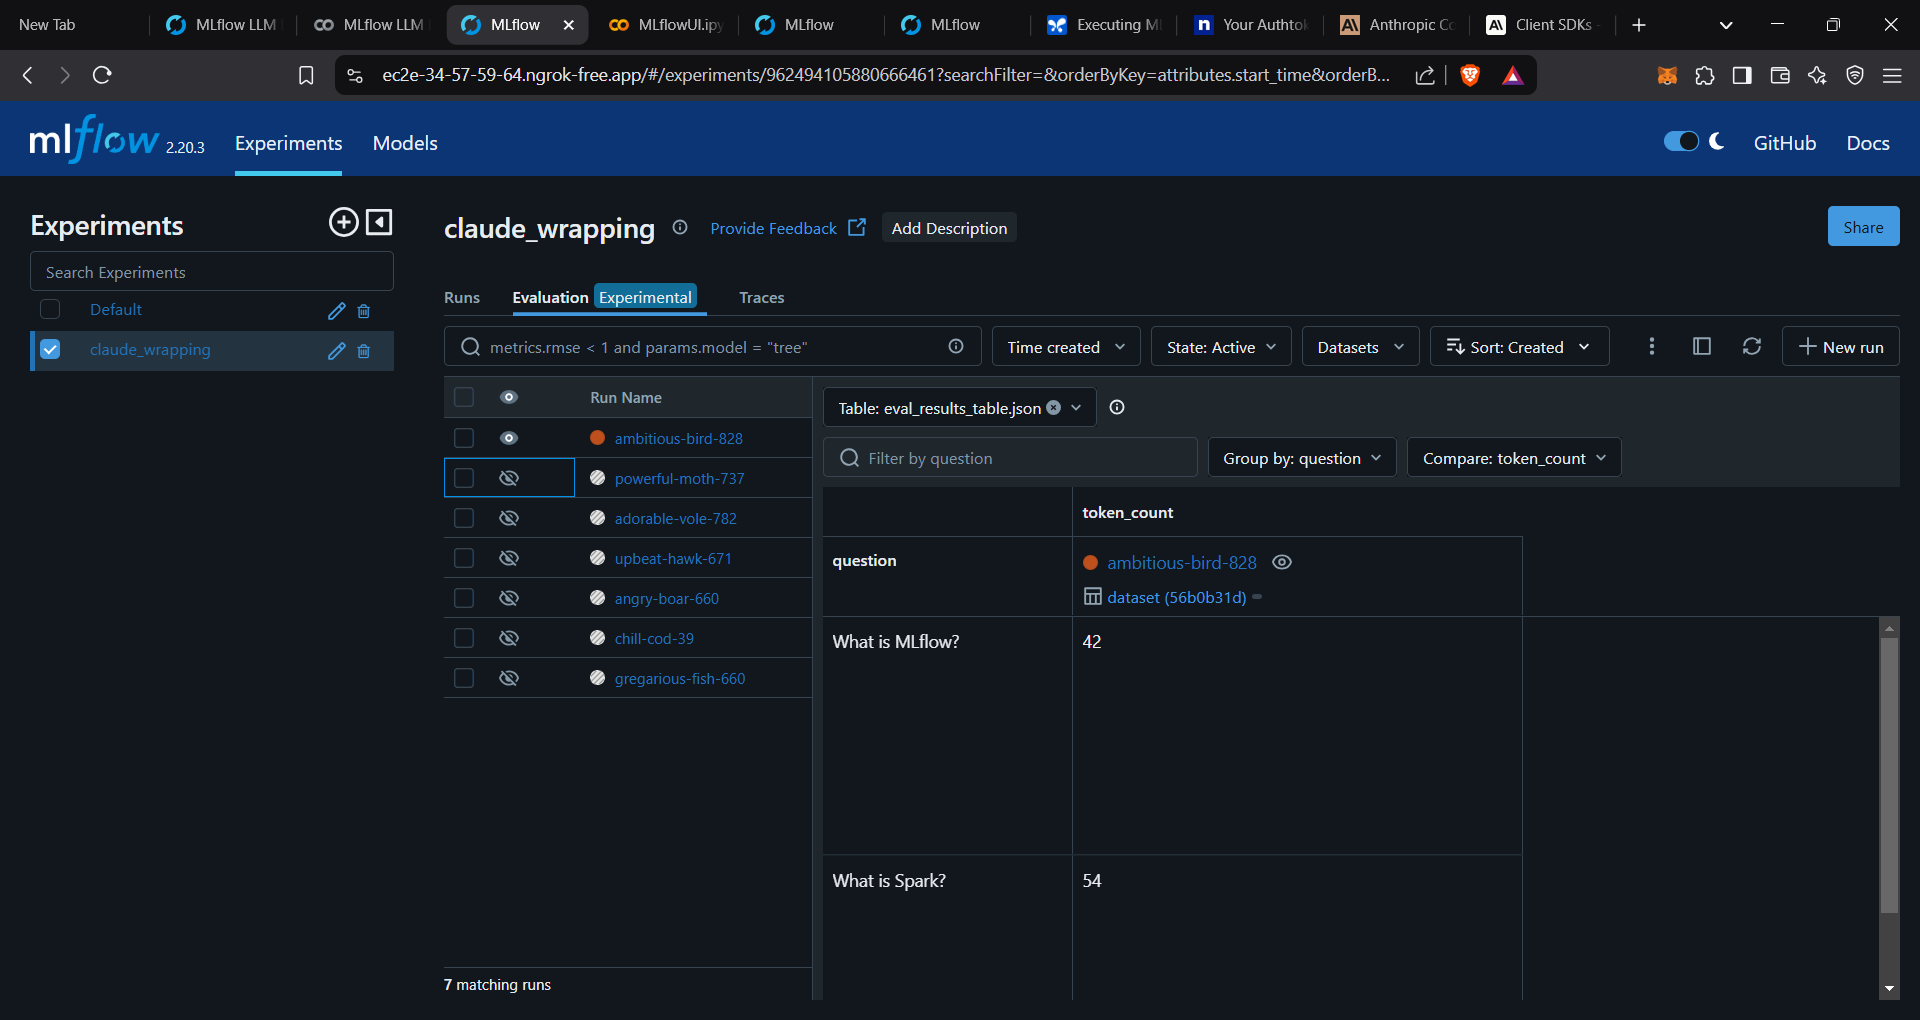
